# **Traffic Dataset Preprocessing**

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns


from utils import *

datasets_folder = './datasets'
starting_date = datetime(2019,1,1)

## Data Import


In [2]:
traffic_folder = os.path.join(datasets_folder,'traffic')

readings_df = merge_csv_to_dataframe(os.path.join(traffic_folder, 'readings'), sep=';')
accuracies_df = merge_csv_to_dataframe(os.path.join(traffic_folder, 'accuracies'), sep=';')

display(readings_df.head(3))
display(accuracies_df.head(3))

Merged 6 CSV files
Merged 6 CSV files


,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,stato,codimpsem,direzione,angolo,longitudine,latitudine,geopoint,ID_univoco_stazione_spira,Giorno della settimana,giorno settimana
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,A,318.0,S,170.0,11.347424,44.500815,"44.5008152038968, 11.3474244254298",15.0,Martedì,NaN
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,A,316.0,N,350.0,11.338970,44.495251,"44.4952505129043, 11.338970003537",2.0,Martedì,NaN
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,16,...,A,324.0,S,168.0,11.343443,44.490027,"44.4900271601578, 11.3434427397635",7.0,Martedì,NaN


,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
0,2019-01-14,4.30 4.96 4 1,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
1,2019-01-14,4.31 4.29 6 1,100%,100%,100%,95%,58%,87%,100%,100%,...,83%,91%,100%,100%,91%,79%,95%,87%,95%,100%
2,2019-01-14,4.31 4.39 4 1,100%,100%,100%,100%,66%,83%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%


Let's check for not informative columns

In [3]:
print(readings_df.columns)

Index(['data', 'codice spira', '00:00-01:00', '01:00-02:00', '02:00-03:00',
       '03:00-04:00', '04:00-05:00', '05:00-06:00', '06:00-07:00',
       '07:00-08:00', '08:00-09:00', '09:00-10:00', '10:00-11:00',
       '11:00-12:00', '12:00-13:00', '13:00-14:00', '14:00-15:00',
       '15:00-16:00', '16:00-17:00', '17:00-18:00', '18:00-19:00',
       '19:00-20:00', '20:00-21:00', '21:00-22:00', '22:00-23:00',
       '23:00-24:00', 'id_uni', 'Livello', 'tipologia', 'codice',
       'codice arco', 'codice via', 'Nome via', 'Nodo da', 'Nodo a',
       'ordinanza', 'stato', 'codimpsem', 'direzione', 'angolo', 'longitudine',
       'latitudine', 'geopoint', 'ID_univoco_stazione_spira',
       'Giorno della settimana', 'giorno settimana'],
      dtype='object')


We drop a bunch of them

In [4]:
readings_df = readings_df.drop(columns=[
    'id_uni',
    'Livello',
    'tipologia',
    'codice',
    'codice arco',
    'codice via',
    'Nome via',
    'Nodo da',
    'Nodo a',
    'ordinanza',
    'stato',
    'codimpsem',
    'direzione',
    'angolo',
    'longitudine',
    'latitudine',
    'ID_univoco_stazione_spira',
    'Giorno della settimana',
    'giorno settimana'
])

In [5]:
readings_df = readings_df.dropna()
readings_df

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00,geopoint
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,305,292,311,222,161,116,79,67,57,"44.5008152038968, 11.3474244254298"
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,68,85,101,55,81,64,50,36,27,"44.4952505129043, 11.338970003537"
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,16,...,33,35,34,45,34,49,25,28,14,"44.4900271601578, 11.3434427397635"
3,2019-01-01,0.127 1.18 1 1,22,23,20,16,14,22,34,35,...,41,46,44,51,54,53,27,17,20,"44.4992226472054, 11.338564528943"
4,2019-01-01,0.127 1.18 2 1,119,190,185,130,62,66,47,50,...,150,176,214,158,155,204,119,114,70,"44.4992331807033, 11.3385147346639"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788560,2024-11-30,4.91 4.36 8 1,213,131,87,52,33,51,96,217,...,531,557,617,633,581,463,259,227,288,"44.4785683027768, 11.3804873332989"
1788561,2024-11-30,4.93 4.92 6 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"44.4843292671686, 11.3685493809408"
1788562,2024-11-30,4.96 4.92 4 1,75,51,34,12,13,32,50,170,...,241,296,273,245,277,205,156,130,128,"44.4829011144397, 11.371762568121"
1788563,2024-11-30,4.98 4.98 3 1,56,34,19,11,10,20,45,66,...,176,168,189,179,161,102,60,55,81,"44.4689700816957, 11.3852604232066"


## Accuracies

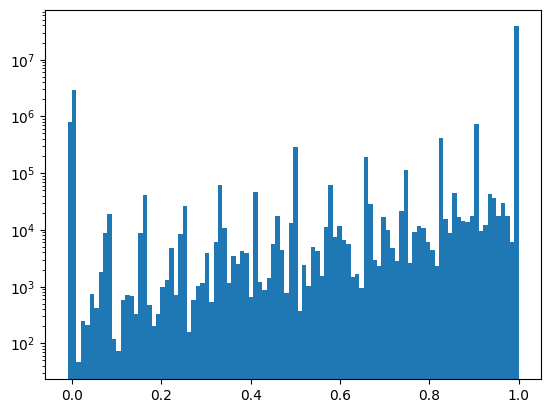

In [6]:
accuracies_df = convert_percentage_to_number(accuracies_df)
v,c=np.unique(np.array(accuracies_df[accuracies_df.columns[2:]]), return_counts=True)
unique_values_array = np.array([v, c]).T
np.set_printoptions(suppress=True)
a=unique_values_array[np.argsort(unique_values_array[:, 0])]
plt.yscale('log')
plt.hist(a[:, 0], bins=len(a[:, 0]), weights=a[:, 1])
plt.show()

oh damn there are -0.01! lets map them to 0

In [7]:
# Define the function to apply
def map_values(x):
    if x == -0.01:
        return 0
    return x

# Apply the function to every item in the dataframe
accuracies_df = accuracies_df.map(map_values)

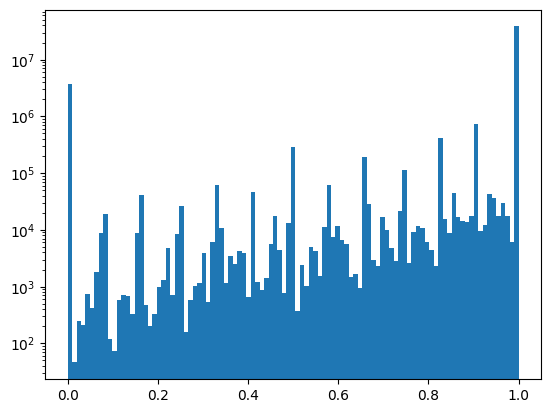

In [8]:
v,c=np.unique(np.array(accuracies_df[accuracies_df.columns[2:]]), return_counts=True)
unique_values_array = np.array([v, c]).T
np.set_printoptions(suppress=True)
a=unique_values_array[np.argsort(unique_values_array[:, 0])]
plt.yscale('log')
plt.hist(a[:, 0], bins=len(a[:, 0]), weights=a[:, 1])
plt.show()


In [9]:
common_cols = readings_df.columns.intersection(accuracies_df.columns).tolist()

accurate_traffic_df = apply_accuracy_df(readings_df[common_cols],accuracies_df[common_cols],max_multiplier=15, half_multiplier=2).reset_index(drop=True)
readings_df = readings_df.reset_index(drop=True)
for col in list(set(readings_df.columns) - set(common_cols)): # add back readings columns
    accurate_traffic_df[col] = readings_df[col]

In [10]:
accurate_traffic_df

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00,geopoint
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,305,292,311,222,161,116,79,67,57,"44.5008152038968, 11.3474244254298"
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,68,85,101,55,81,64,50,36,27,"44.4952505129043, 11.338970003537"
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,19,...,33,35,34,45,34,49,25,28,14,"44.4900271601578, 11.3434427397635"
3,2019-01-01,0.127 1.18 1 1,22,23,20,16,14,24,34,35,...,41,46,44,51,54,53,27,17,20,"44.4992226472054, 11.338564528943"
4,2019-01-01,0.127 1.18 2 1,119,190,185,130,62,72,47,50,...,150,176,214,158,155,204,119,114,70,"44.4992331807033, 11.3385147346639"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785118,2024-11-30,4.91 4.36 8 1,213,131,87,52,33,51,96,217,...,531,557,617,633,581,463,259,227,288,"44.4785683027768, 11.3804873332989"
1785119,2024-11-30,4.93 4.92 6 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"44.4843292671686, 11.3685493809408"
1785120,2024-11-30,4.96 4.92 4 1,75,51,34,12,13,32,50,170,...,241,296,273,245,277,205,156,130,128,"44.4829011144397, 11.371762568121"
1785121,2024-11-30,4.98 4.98 3 1,56,34,19,11,10,20,45,66,...,176,168,189,179,161,102,60,55,81,"44.4689700816957, 11.3852604232066"


## Locality of the readings

In [ ]:
giardini_margherita_geopoint = '44.482671138769533,11.35406170088398'
san_felice_geopoint = '44.499059983334519,11.327526717440112'
chiarini_geopoint = '44.499134335170289,11.285089594971216'

center_points = {
    "Giardini Margherita": giardini_margherita_geopoint,
    "Porta San Felice": san_felice_geopoint,
    "Via Chiarini": chiarini_geopoint
}

radius = 1  # km

aux = accurate_traffic_df.copy()
aux['lat'] = aux['geopoint'].apply(lambda x: float(x.split(',')[0]))
aux['lon'] = aux['geopoint'].apply(lambda x: float(x.split(',')[1]))

for distance_function in (
    haversine, 
    # adaptive_haversine, 
    # ecef_distance
    ):
    plt.figure(figsize=(8, 8))
    plt.scatter(aux['lon'], aux['lat'], label="All coils", alpha=0.5)

    colors = ['red', 'blue', 'green']
    for (label, center), color in zip(center_points.items(), colors):
        lat, lon = map(float, center.split(','))
        circle = plt.Circle((lon, lat), 1 / 111, color=color, fill=False, linestyle="--")
        plt.scatter(lon, lat, c=color, marker='x', s=100)
        station_traffic = search_close_readings(aux, center, radius, method=distance_function)
        plt.scatter(station_traffic['lon'], station_traffic['lat'], c=color, alpha=0.7, label=f"{label}")
        plt.gca().add_patch(circle)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='lower left')
    plt.title("Coils around the pollution stations")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


## Create hour data from multiple coils

In [12]:
station_traffic = {}
station_traffic['GIARDINI MARGHERITA'] = search_close_readings(accurate_traffic_df, giardini_margherita_geopoint, radius)
station_traffic['GIARDINI MARGHERITA'] = station_traffic['GIARDINI MARGHERITA'].drop(columns=['geopoint', 'codice spira']) 
station_traffic['GIARDINI MARGHERITA'].head(5)

,data,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,08:00-09:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
5,2019-01-01,20,55,58,22,15,10,13,8,9,...,20,37,33,33,43,34,44,34,21,9
64,2019-01-01,23,18,19,23,11,16,18,19,17,...,53,47,42,56,73,88,56,32,25,13
67,2019-01-01,64,84,79,37,30,12,19,16,20,...,47,74,76,68,77,68,52,39,20,26
68,2019-01-01,45,103,86,33,29,15,18,25,29,...,85,89,105,112,137,102,79,68,48,33
72,2019-01-01,200,469,407,228,104,64,58,112,117,...,328,342,325,455,447,386,315,167,146,108


Inspecting the dataframe, we can notice that we have as many features as the hours of the day. We want to have a singular value referring to the traffic hour. To do so, we sum all the traffic readings from all the coils of that hour.

<Axes: xlabel='Hour'>

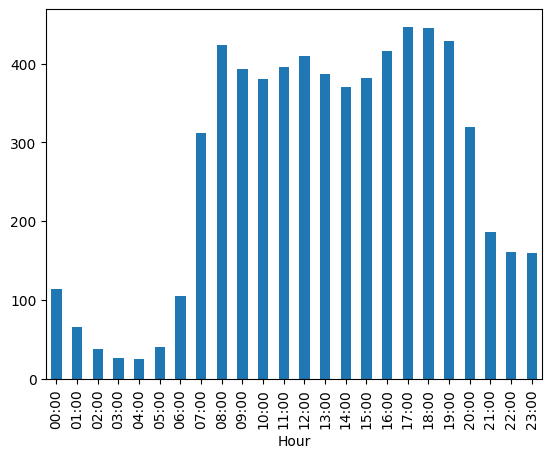

In [13]:
station_traffic_melted = {}
station_traffic_melted['GIARDINI MARGHERITA'] = station_traffic['GIARDINI MARGHERITA'].melt(id_vars=["data"], var_name="Hour", value_name="Traffic_value")
station_traffic_melted['GIARDINI MARGHERITA']['Hour'] = station_traffic_melted['GIARDINI MARGHERITA']['Hour'].apply(lambda x: x.split('-')[0])
station_traffic_melted['GIARDINI MARGHERITA'].groupby('Hour')['Traffic_value'].mean().plot(kind='bar')

From the plot we can see the average traffic data across all the days. As we might expect, during the night the traffic is really low. During clock-in and clock-out hours the traffic peaks.

To proceed, we have to move the columns into rows and sum all the rows with the same index, so same date and hour.

In [14]:
s = 'GIARDINI MARGHERITA'
station_traffic_melted[s]['data'] = pd.to_datetime(station_traffic_melted[s]['data'] + ' ' + station_traffic_melted[s]['Hour'])
station_traffic_melted[s] = station_traffic_melted[s].rename(columns={'data': 'Date'})
station_traffic_melted[s] = station_traffic_melted[s].drop(columns=['Hour'])
station_traffic_melted[s] = station_traffic_melted[s].groupby('Date', as_index=False)['Traffic_value'].sum()

In [15]:
station_traffic_melted['GIARDINI MARGHERITA'].head(5)

,Date,Traffic_value
0,2019-01-01 00:00:00,10501
1,2019-01-01 01:00:00,16863
2,2019-01-01 02:00:00,15248
3,2019-01-01 03:00:00,9844
4,2019-01-01 04:00:00,6202


## Traffic visualization

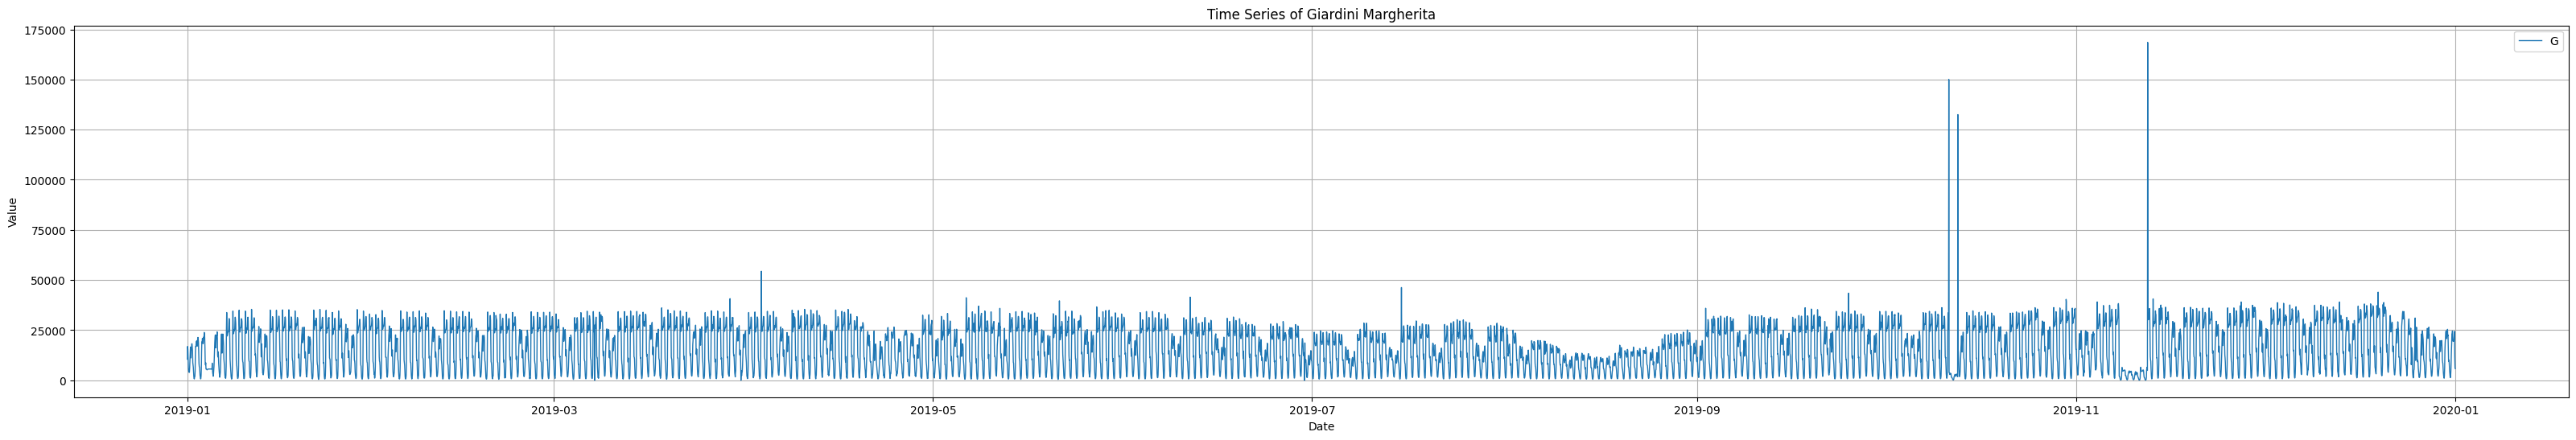

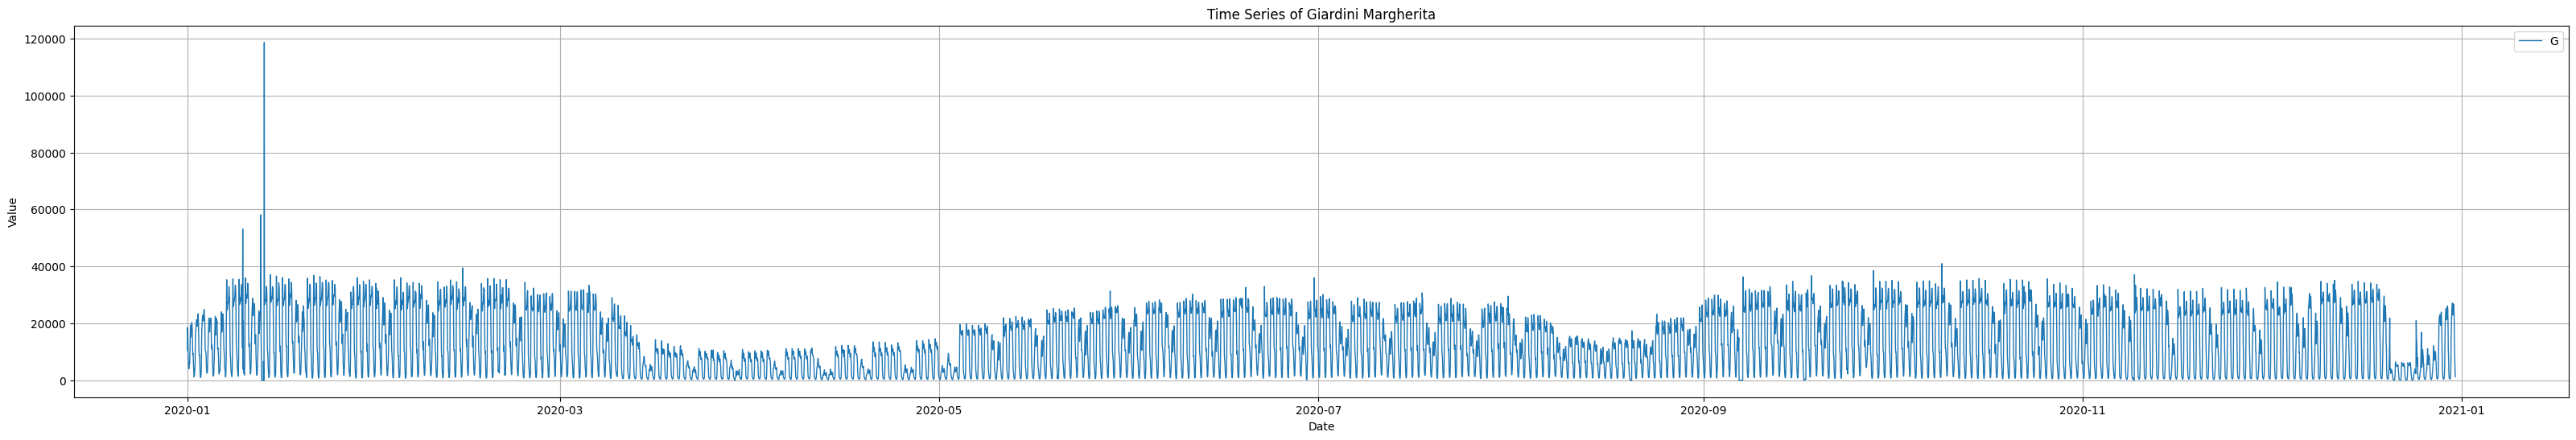

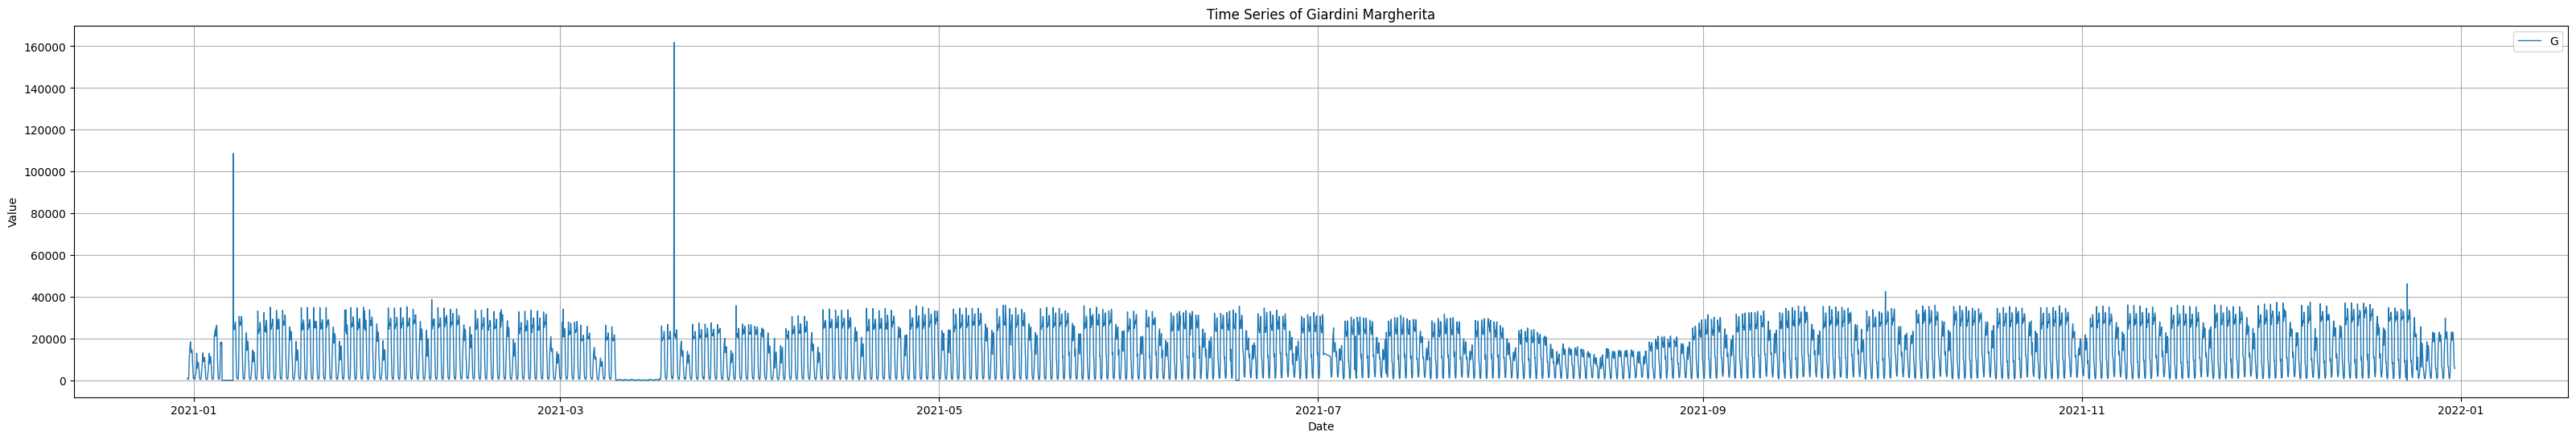

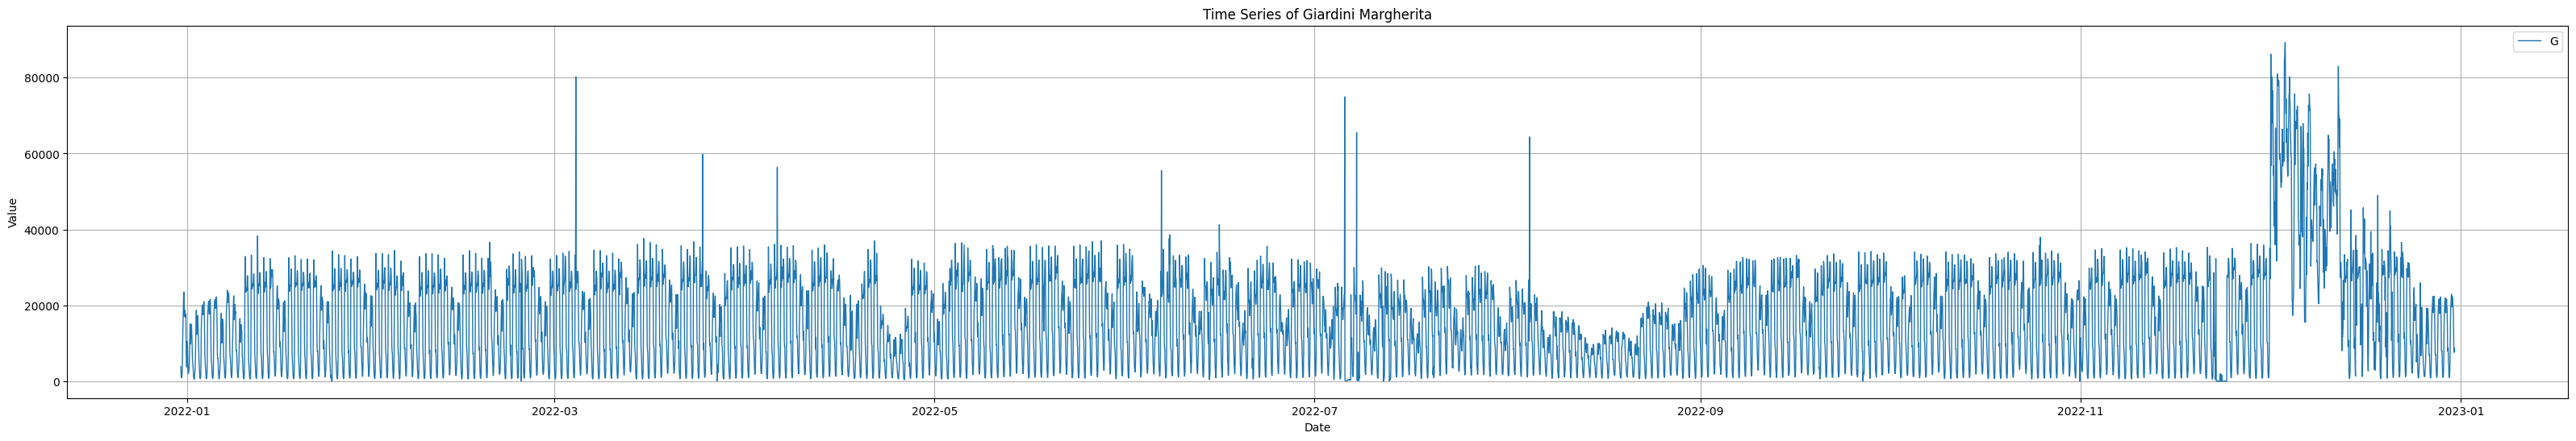

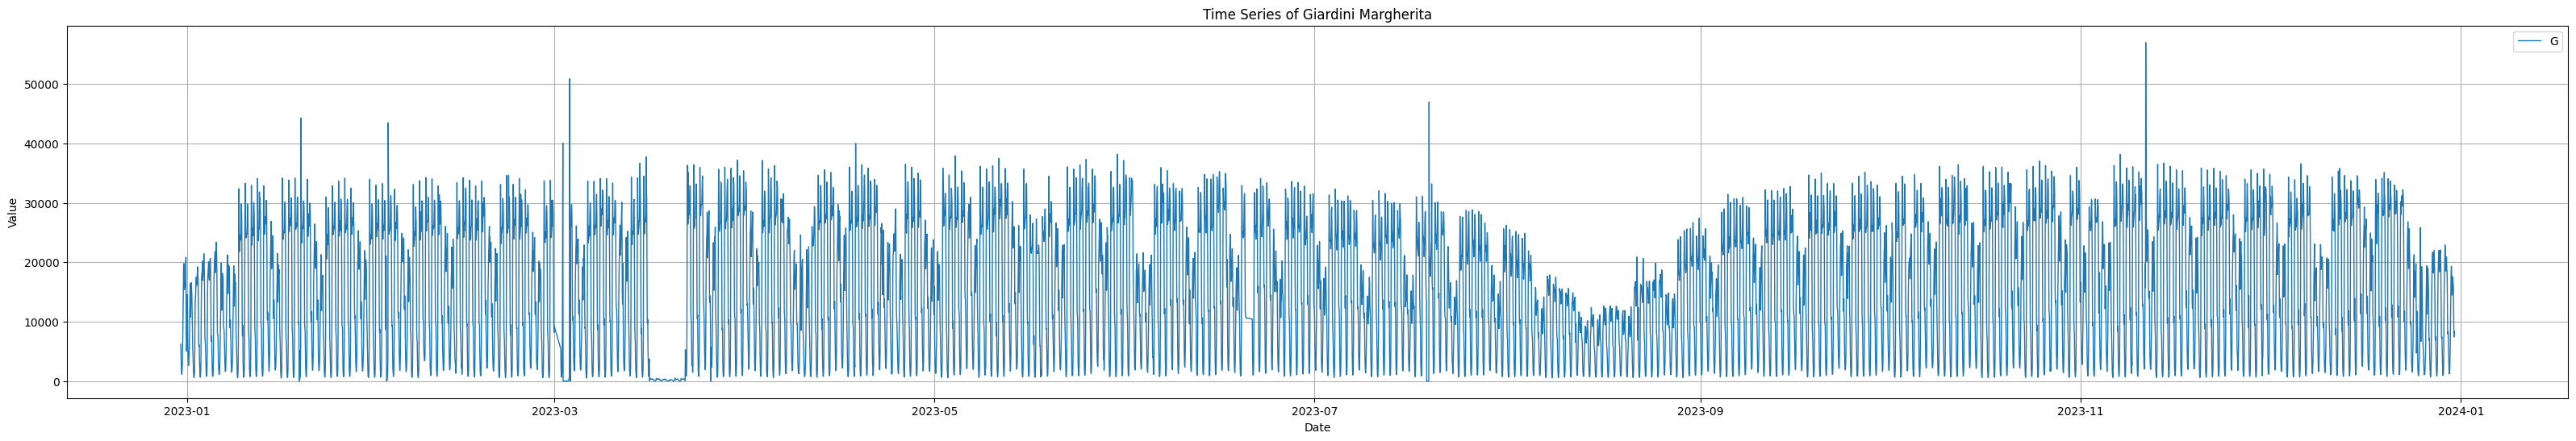

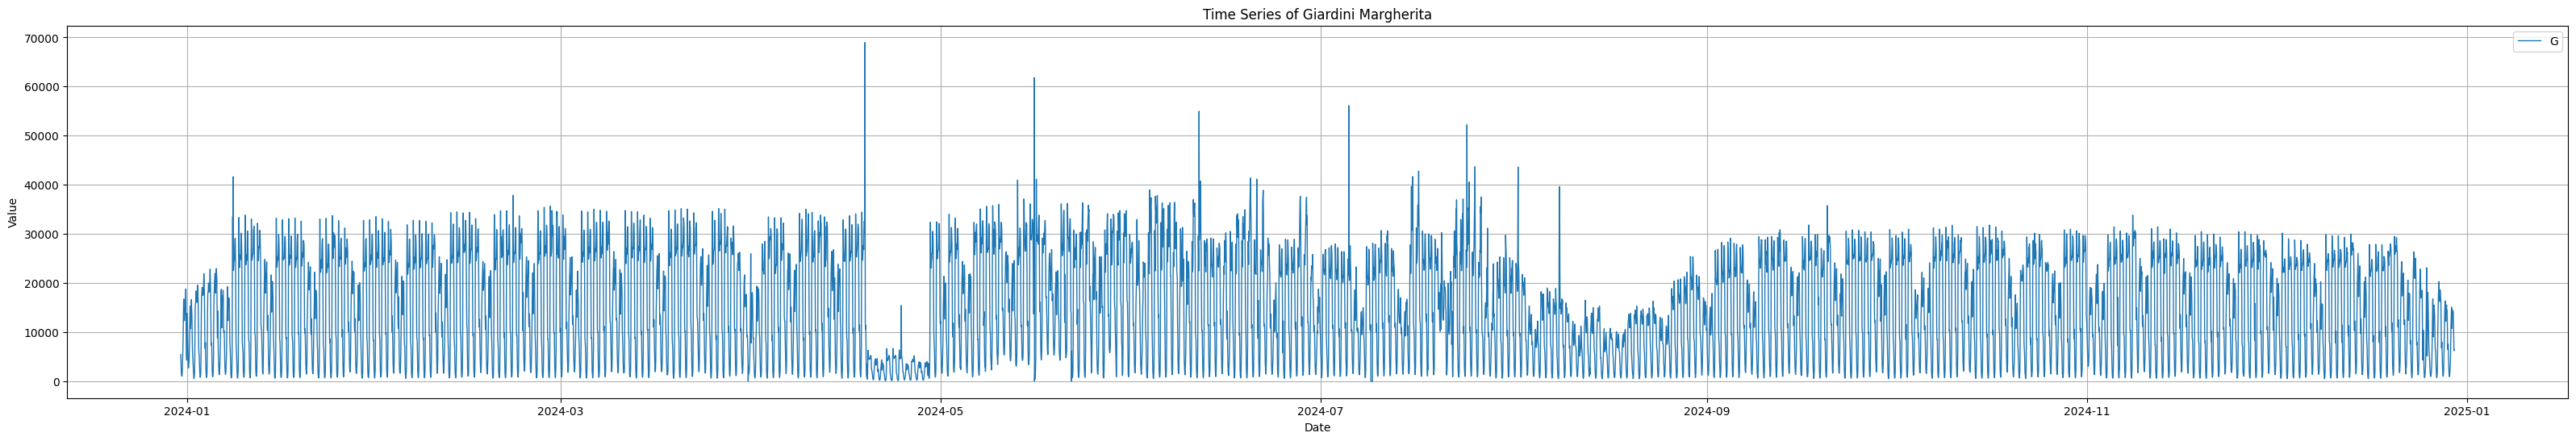

In [16]:
starting_date = datetime(2019,1,1)
ending_date = datetime(2024,12,31,23)
period = timedelta(days=365)
s = 'GIARDINI MARGHERITA'

for i in range((ending_date-starting_date) // period):
    start = starting_date + i*period
    end = min(starting_date + (i + 1) * period, ending_date)
    plot_time_series([station_traffic_melted[s]],  'Traffic_value','Date', "Giardini", start_date=start, end_date=end,  max_rows=500000, title='Giardini Margherita')

Ogni tanto ci sono degli outlier della madonna. Ogni tanto sembra manchino dei valori, ma in realta se si zooma sullo specifico periodo ci sono, sono solo molte meno macchine. Come se alcune spire fossero state spente.

Fill eventual missing hours with zeros.

In [17]:
s= 'GIARDINI MARGHERITA'
station_traffic_melted[s] = station_traffic_melted[s].resample('1h', on='Date').mean().reset_index().fillna(0)
station_traffic_melted[s]

,Date,Traffic_value
0,2019-01-01 00:00:00,10501.0
1,2019-01-01 01:00:00,16863.0
2,2019-01-01 02:00:00,15248.0
3,2019-01-01 03:00:00,9844.0
4,2019-01-01 04:00:00,6202.0
...,...,...
52603,2024-12-31 19:00:00,16224.0
52604,2024-12-31 20:00:00,16488.0
52605,2024-12-31 21:00:00,6852.0
52606,2024-12-31 22:00:00,4162.0


## **Daily Data**

In order to convert hourly data to daily data to evaluate daily agents, we can:
- Average or sum the values of each day
- Bin them into columns as a feature. For example we might want to pack 8 hours and have the total traffic of 00AM-8AM, 8AM-16PM and 16PM-24PM.

Let's take as example one day of data:

In [18]:
start = datetime(2019,2,1) # in january there is new year eve and data is a bit less representative
end = datetime(2019,2,2)

tmp = station_traffic_melted['GIARDINI MARGHERITA'].set_index('Date')
one_day_df = tmp[(tmp.index>=start)&(tmp.index<end)]
print(f'Number of hours: {len(one_day_df)}')
print(f'Total traffic: {one_day_df.sum()}')
one_day_df.head(5)

Number of hours: 24
Total traffic: Traffic_value    455374.0
dtype: float64


,Traffic_value
Date,
2019-02-01 00:00:00,7284.0
2019-02-01 01:00:00,2891.0
2019-02-01 02:00:00,1185.0
2019-02-01 03:00:00,786.0
2019-02-01 04:00:00,1082.0


We can try different bin sizes, like the one proposed earlier:

In [19]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=8)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 455374.0


,Traffic_0-7,Traffic_8-15,Traffic_16-0
Date,,,
2019-02-01,47763.0,222880.0,184731.0


...or a sparser one, using 4 hours:

In [20]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=4)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 455374.0


,Traffic_0-3,Traffic_4-7,Traffic_8-11,Traffic_12-15,Traffic_16-19,Traffic_20-0
Date,,,,,,
2019-02-01,12146.0,35617.0,114165.0,108715.0,122279.0,62452.0


*note that the sums holds across the hours*

A reasonable idea is to have morning, noon and night:
- night: 22-6 -> the last 2 hours of the day before plus 00 to 06
- morning: 6-14
- noon: 14-22

The 24 hours used are not from the same day, so in hour case we only compose the day using 22 hours (the last 2 hours would be used for the next day)

Since that the hous are not aligned with the start of the day, we can use the `offset` parameter.

In [59]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=8, offset=2, dropna=False)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 455374.0


,Traffic_2-9,Traffic_10-17,Traffic_18-2
Date,,,
2019-01-31,NaN,NaN,10175.0
2019-02-01,100729.0,220203.0,124267.0


Since that the offset is 2, the first two hours of each day are used by the previous day for their last bin.